In [22]:
import pandas as pd
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy
from scipy import stats
from scipy.signal import welch, stft, spectrogram
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
import re
import pywt
from numpy.fft import rfft, rfftfreq
import copy
import json

mpl.rcParams['agg.path.chunksize'] = 10000000

In [23]:
def is_number(s):
    # Define a regex pattern to match positive, negative, and decimal numbers
    number_pattern = re.compile(r'^-?(\d+(\.\d*)?|\.\d+)$')
    
    # Use the pattern to check if the string matches
    return bool(number_pattern.match(s))

def truncate_microseconds(dt_str):
    # Split the time string at the decimal point
    if '.' in dt_str:
        time_part, microseconds_part = dt_str.split('.')
        # Truncate to only the first six digits of microseconds
        truncated_microseconds_part = microseconds_part[:6]
        truncated_dt_str = f"{time_part}.{truncated_microseconds_part}"
        return truncated_dt_str
    return dt_str

In [24]:
experiment_raw_df = {}
filter_signal = ""

In [25]:
accelerometer_filepath = ""
while True:
    # Specify the file path directly
    accelerometer_filename = input("Please enter the name of your accelerometer file: ")
    accelerometer_folder = input("Please enter the full path (not including the filename) to your .lvm or .txt file: ")

    if accelerometer_folder:
        accelerometer_filepath = accelerometer_folder + "\\" + accelerometer_filename
    else: 
        accelerometer_filepath = accelerometer_filename

    print("\Accelerometer Data Filepath: ", accelerometer_filepath)

    if os.path.isfile(accelerometer_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

\Accelerometer Data Filepath:  \\10.1.90.19\Files\Stephen\FL Tests\FL-102\FL-102.csv


In [26]:
def import_csv_to_df(filepath, delimiter=','):
    raw_df = pd.read_csv(filepath, delimiter=delimiter, header=0)  # Assume first line is header
    raw_df = raw_df.dropna(axis=1, how='all')
    return raw_df

raw_df = import_csv_to_df(accelerometer_filepath)
# raw_df = process_lvm_data(raw_df, FL_metadata)

display(raw_df)

,Chan 0,Chan 1
0,-0.912502,-1.003768
1,-0.836249,-0.981843
2,-0.917382,-1.109742
3,-0.902741,-1.009859
4,-0.940563,-0.966008
...,...,...
5812198,-0.861260,-1.221806
5812199,-0.967404,-1.310727
5812200,-1.002175,-1.363105
5812201,-0.930802,-1.256522


In [27]:
# Define the sample interval (in seconds)
sampling_frequency = 51200  # Hz
sample_interval = 1./sampling_frequency  # s

# Create 'Time (s)' column as a multiplier on the index
time_col_name = 'Time (s)'
raw_df[time_col_name] = raw_df.index * sample_interval

# Reorder the columns to place 'Time (s)' at the front
cols = raw_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Time (s)')))
df = raw_df[cols]

print(df)

           Time (s)    Chan 0    Chan 1
0          0.000000 -0.912502 -1.003768
1          0.000020 -0.836249 -0.981843
2          0.000039 -0.917382 -1.109742
3          0.000059 -0.902741 -1.009859
4          0.000078 -0.940563 -0.966008
...             ...       ...       ...
5812198  113.519492 -0.861260 -1.221806
5812199  113.519512 -0.967404 -1.310727
5812200  113.519531 -1.002175 -1.363105
5812201  113.519551 -0.930802 -1.256522
5812202  113.519570 -0.935072 -1.210844

[5812203 rows x 3 columns]


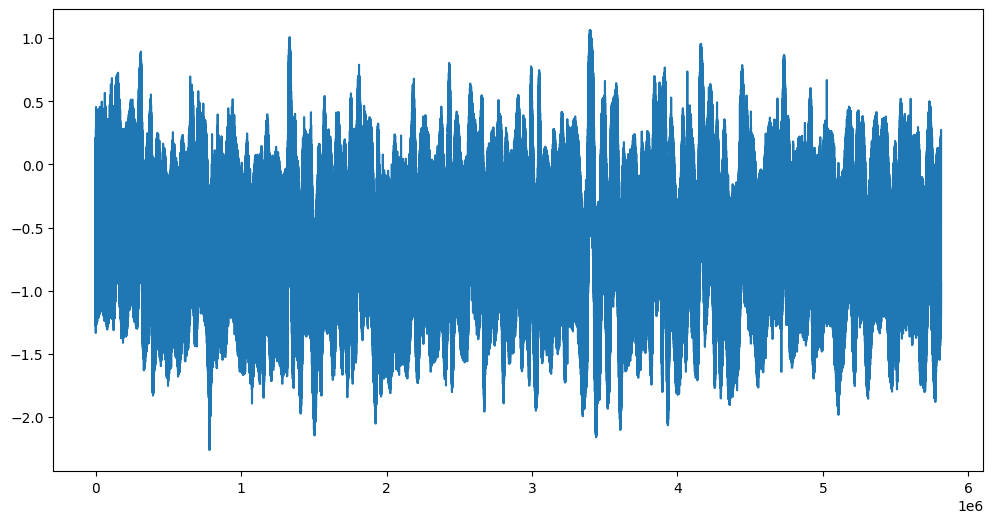

In [28]:
channel_name = "Chan 0"
plt.figure(figsize=(12, 6))
plt.plot(raw_df.index, raw_df[channel_name])
plt.show()

In [29]:
raw_time = raw_df['Time (s)'].values
raw_signal = raw_df[channel_name].values
sampling_period = raw_time[1] - raw_time[0]
sampling_frequency = 1 / sampling_period
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: 51200.0 Hz


## Plot the Raw IEPE Signal

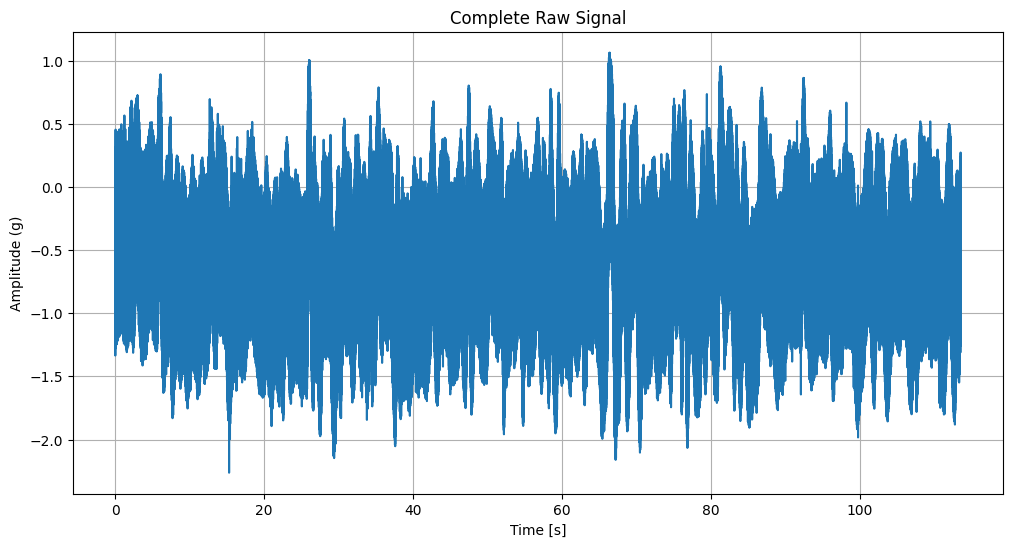

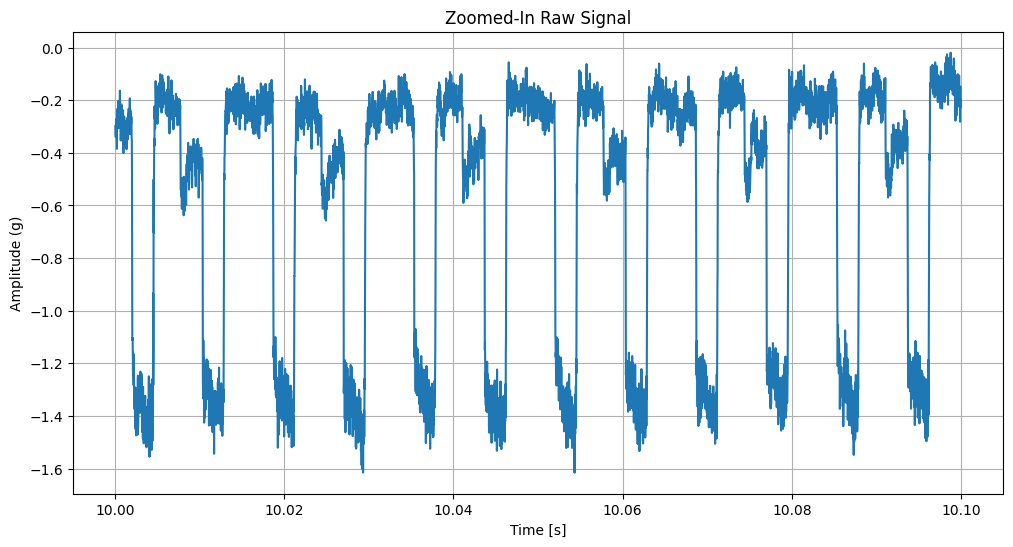

In [30]:
# Complete Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(raw_time, raw_signal)
plt.title(f'Complete Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
# plt.tight_layout()
plt.show()

viewing_xmin = 10
viewing_xmax = viewing_xmin + .1
x_mask = (raw_time > viewing_xmin) & (raw_time < viewing_xmax)

# Zoomed in X-axis
plt.figure(figsize=(12, 6))
plt.plot(raw_time[x_mask], raw_signal[x_mask])
plt.title(f'Zoomed-In Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
# plt.tight_layout()
plt.show()

In [31]:
raise Exception("")

Exception: 

## Time-Mask the IEPE Signal for Power Spectral Density Analysis (Optional)

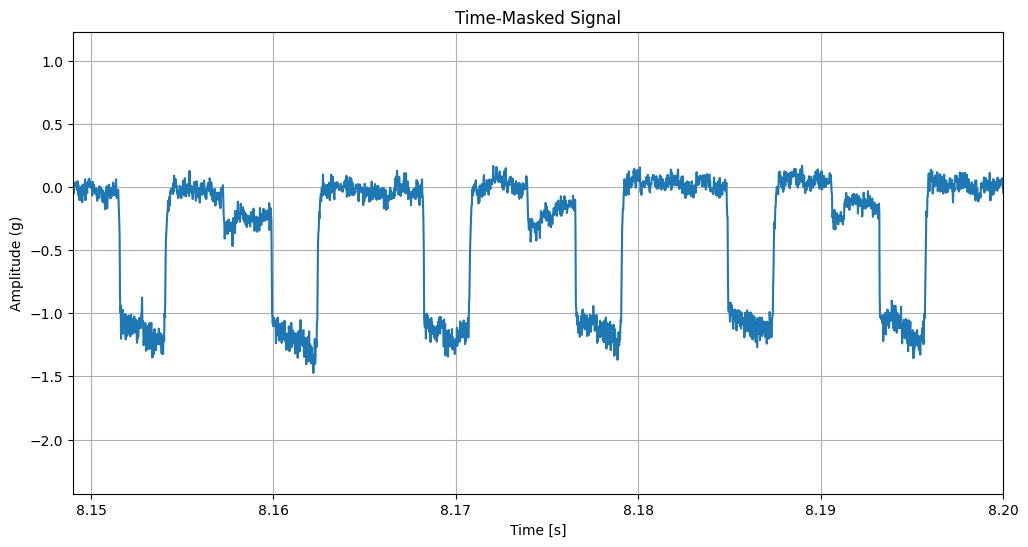

In [32]:
start_time = 0
end_time = None
mask = (raw_time > start_time)
if end_time is not None:
    mask = (raw_time > start_time) & (raw_time < end_time)

masked_raw_time = raw_time[mask]
masked_raw_signal = raw_signal[mask]

# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(masked_raw_time, masked_raw_signal)
plt.xlim(left=8.149, right=8.2)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Plot the Fourier Transform and Power Spectrum

Signal RMS: 0.6934531414494823 V
Min Power: -76.22827064568841 dB
Max Power: -27.659790954964294 dB


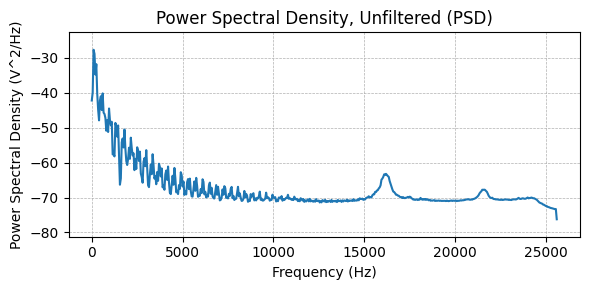

In [33]:
# Compute the Signal RMS
signal_rms = np.sqrt(np.mean(np.square(masked_raw_signal)))
print(f"Signal RMS: {signal_rms} V")

# Compute the Power Spectral Density (PSD)
psd_frequencies, psd = welch(masked_raw_signal, fs=sampling_frequency, nperseg=1024)
# Convert PSD to dB Scale
psd_db = 10 * np.log10(psd)

psd_min = np.min(psd)
psd_max = np.max(psd)

psd_db_min = np.min(psd_db)
psd_db_max = np.max(psd_db)

print(f"Min Power: {psd_db_min} dB")
print(f"Max Power: {psd_db_max} dB")

# Plotting the PSD on a log scale
plt.figure(figsize=(6,3))
# plt.semilogx(psd_frequencies, psd_db)
plt.plot(psd_frequencies, psd_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V^2/Hz)")
plt.ylim([psd_db_min-5, psd_db_max+5])
plt.title("Power Spectral Density, Unfiltered (PSD)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## STFT Spectrogram

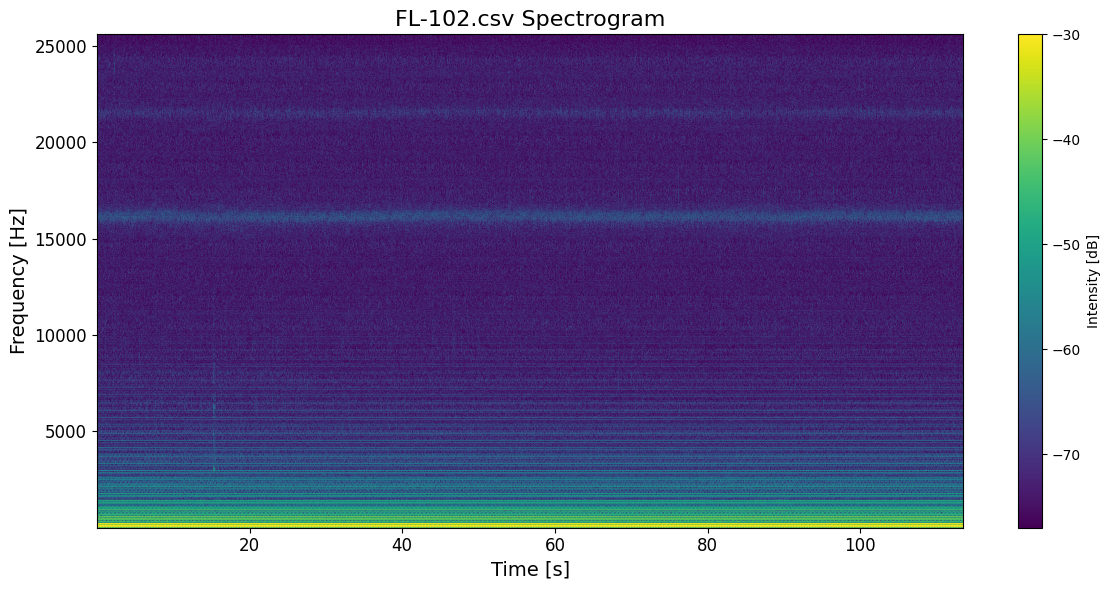

In [34]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(masked_raw_signal, sampling_frequency, nperseg=1024)

# Convert the spectrogram to a log scale (adding a small constant to avoid log(0))
Sxx_log = 10 * np.log10(Sxx + 1e-10)

# Create add the start_time to the times array
times = times + start_time

# min_spectrogram_value_ctrl = psd_db_min
# max_spectrogram_value_ctrl = psd_db_max
min_spectrogram_value_ctrl = -30
max_spectrogram_value_ctrl = -70

# Plot the spectrogram using axes object
pcm = ax.pcolormesh(times, frequencies, 10 * np.log10(Sxx), 
                    shading='gouraud', 
                    vmin=min_spectrogram_value_ctrl, 
                    vmax=max_spectrogram_value_ctrl)

# Set axis limits and labels
ax.set_ylim(1, sampling_frequency/2)
ax.set_ylabel('Frequency [Hz]', fontsize=14)
ax.set_xlabel('Time [s]', fontsize=14)

# Set title
ax.set_title(f'{accelerometer_filename} Spectrogram', fontsize=16)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Add colorbar
fig.colorbar(pcm, ax=ax, label='Intensity [dB]')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

## Checkpoint Before Proceeding with CWT/DWT Analysis

In [35]:
try:
    while True:
        user_input = input("Do you want to run CWT/DWT Analysis? Type 'Y/n' to continue: ")
        if user_input.lower() == 'n':
            raise Exception("Execution stopped by user.")
        elif user_input.lower() == 'y':
            break
except Exception as e:
    print(e)
    # Prevent further cells from executing
    raise

## Generate a Synthetic Signal Based on the Power Spectrum of the Time-Masked Raw Signal to Compare Spectrogram Results with

[2993.86338213 2994.04487913 2994.22636512 ...   59.55945409   59.55438682
    0.        ]
[-0.95333378-0.30191837j -0.21698192-0.97617562j -0.79868996-0.60174275j
 ... -0.4520892 -0.89197273j -0.92271775-0.38547627j
  0.99980822+0.01958353j]
[7.70817303e-05 4.89159721e-04 1.25644084e-03 1.17294918e-03
 6.22428950e-04 4.70459139e-04 2.06648641e-04 4.82021295e-05
 3.06108197e-05 5.45621459e-05 6.48713500e-05 5.64231669e-05
 6.66231817e-05 4.15554659e-05 2.45577176e-05 1.79820506e-05
 1.24338420e-05 1.29218124e-05 1.56848615e-05 2.50464786e-05
 1.95142259e-05 1.35787722e-05 1.12445175e-05 4.66121064e-06
 1.90985644e-06 4.27333952e-06 1.02651847e-05 1.01489147e-05
 8.04876670e-06 8.09917215e-06 3.57781438e-06 7.05714689e-07
 1.12412306e-06 3.28253165e-06 4.21007674e-06 4.53604731e-06
 6.08775894e-06 3.59513453e-06 1.42202543e-06 1.02645946e-06
 1.48857800e-06 2.08572312e-06 2.43923307e-06 3.73478179e-06
 2.93642880e-06 1.90332904e-06 1.53075278e-06 1.02761715e-06
 1.01659476e-06 1.2619607

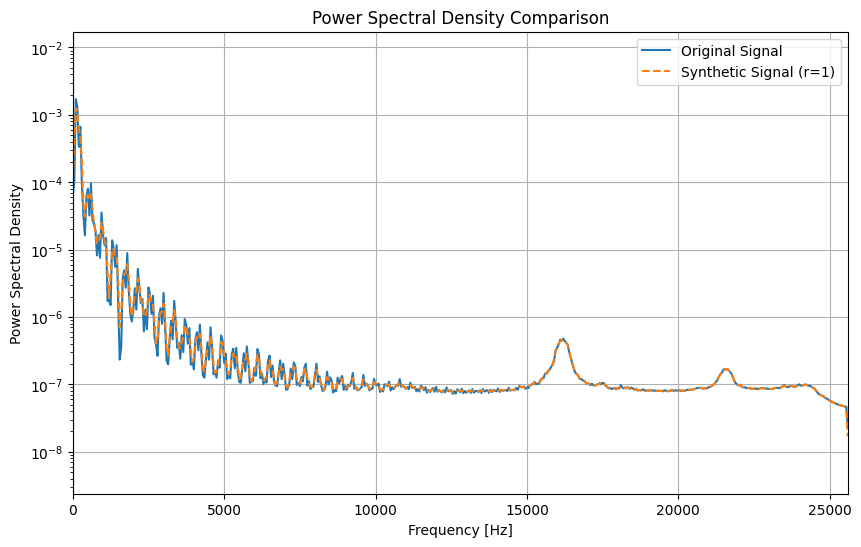

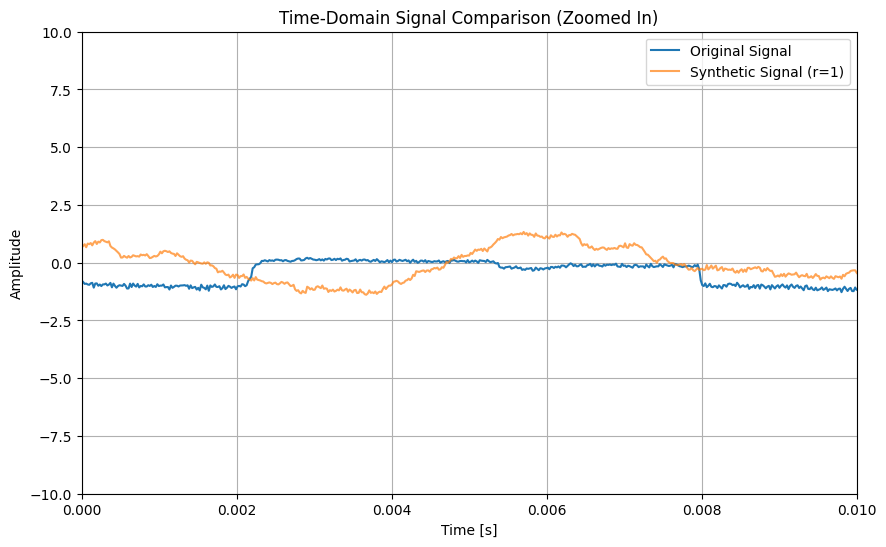

In [36]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import welch
import matplotlib.pyplot as plt

# Define the resolution factor
r = 1  # Change 'r' to your desired resolution factor

# Original signal parameters
N = len(masked_raw_signal)
dt = 1. / sampling_frequency
duration = masked_raw_time[-1] - masked_raw_time[0] + dt

# New sampling frequency and parameters
sampling_frequency_new = sampling_frequency * r
dt_new = 1. / sampling_frequency_new
N_new = int(duration * sampling_frequency_new)

# New time vector
time_synthetic = np.linspace(masked_raw_time[0], masked_raw_time[-1], N_new, endpoint=False)

# Frequency vectors
freqs_new = np.fft.fftfreq(N_new, d=dt_new)
freqs_new_positive = freqs_new[:N_new // 2 + 1]

# Interpolate PSD to new frequencies up to the original Nyquist frequency
max_freq = sampling_frequency / 2
mask = freqs_new_positive <= max_freq
freqs_interp = freqs_new_positive[mask]
interp_psd = interp1d(psd_frequencies, psd, kind='linear', bounds_error=False, fill_value=0)
psd_interp = interp_psd(freqs_interp)

# Compute amplitude spectrum
# The factor of 2 accounts for the energy in negative frequencies
# The sqrt(N_new) factor is to match the scaling of np.fft.fft
amplitude_spectrum = np.zeros(len(freqs_new_positive))
amplitude_spectrum[mask] = np.sqrt(1/2 * psd_interp * sampling_frequency_new * N_new)
print(amplitude_spectrum)

# Generate random phases
np.random.seed(0)  # For reproducibility; remove or change for different results
random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs_new_positive)))
print(random_phases)

# Construct the positive frequency components
fft_positive = amplitude_spectrum * random_phases

# Construct the full FFT spectrum with Hermitian symmetry
if N_new % 2 == 0:
    # N_new is even
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:N_new // 2] = fft_positive[1:-1]
    fft_synthetic[N_new // 2] = fft_positive[-1].real  # Nyquist component (real-valued)
    fft_synthetic[N_new // 2 + 1:] = np.conj(fft_positive[1:-1][::-1])
else:
    # N_new is odd
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:(N_new + 1) // 2] = fft_positive[1:]
    fft_synthetic[(N_new + 1) // 2:] = np.conj(fft_positive[1:][::-1])

# Inverse FFT to get the synthetic signal
synthetic_signal = np.fft.ifft(fft_synthetic).real

# Compute the PSD of the synthetic signal
f_synthetic, Pxx_synthetic = welch(synthetic_signal, fs=sampling_frequency_new, nperseg=1024)

print(Pxx_synthetic)

# Plot the PSDs
plt.figure(figsize=(10, 6))
plt.semilogy(psd_frequencies, psd, label='Original Signal')
plt.semilogy(f_synthetic, Pxx_synthetic, label=f'Synthetic Signal (r={r})', linestyle='--')
plt.xlim(0, sampling_frequency/2)
plt.ylim(psd.min()/10, psd.max()*10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Zoom in on the time-domain signals
plt.figure(figsize=(10, 6))
plt.plot(masked_raw_time, masked_raw_signal, label='Original Signal')
plt.plot(time_synthetic, synthetic_signal, label=f'Synthetic Signal (r={r})', alpha=0.7)
plt.xlim(start_time, start_time + .01)  # Adjust the limits as needed
plt.ylim(-10, 10)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal Comparison (Zoomed In)')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
raise Exception("")

Exception: 

## Time-Mask the Signal for Wavelet Analysis (Recommended for Sake of Computation Time)

original
(511999,)
(511999,)


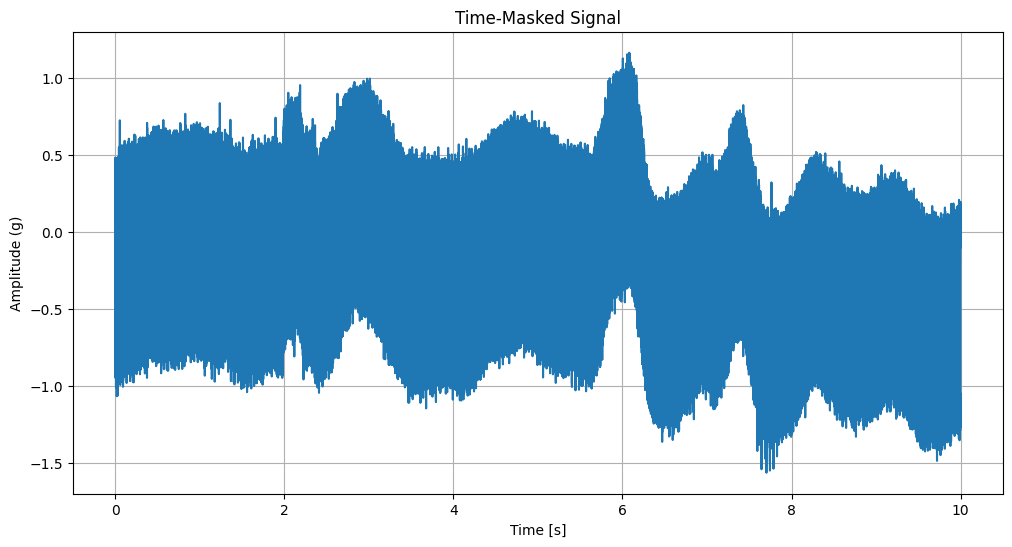

In [43]:
start_time = 0
end_time = 10

original_or_synthetic = ""
while True:
    # Specify whether to generate the scalogram using the orignal or synthetic data
    original_or_synthetic = input("Specify whether to generate the scalogram using the orignal or synthetic data. Type \"original\" or \"synthetic\": ")
    print(original_or_synthetic)

    if original_or_synthetic == "original" or original_or_synthetic == "synthetic":
        break
    else:
        raise Exception("Invalid input. Try again.")

if original_or_synthetic == "original":
    # Process original signal
    mask = (raw_time > start_time)
    if end_time is not None:
        mask = (raw_time > start_time) & (raw_time < end_time)
    time = raw_time[mask]
    signal = raw_signal[mask]
    signal = signal - np.mean(signal)  # Remove any y-axis offset

elif original_or_synthetic == "synthetic":
    # Synthetic signal (for comparison)
    mask = (time_synthetic > start_time)
    if end_time is not None:
        mask = (time_synthetic > start_time) & (time_synthetic < end_time)
    time = time_synthetic[mask]
    signal = synthetic_signal[mask]

print(time.shape)
print(signal.shape)


# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Filter the Signal for Wavelet Analysis (Optional)

In [44]:
filter_signal = ""
while filter_signal != "y":
    # Specify the file path directly
    filter_signal = input("Would you like to filter the signal? (Y/n)")

    if filter_signal.lower() == "y":
        # Define the bandpass filter parameters
        lowcut = 100  # Lower frequency (Hz)
        highcut = 25000  # Upper frequency (Hz)

        # Butterworth bandpass filter design
        def butter_bandpass(lowcut, highcut, fs, order=20):
            nyquist = 0.5 * fs  # Nyquist frequency
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = scipy.signal.butter(order, [low, high], btype='band')
            return b, a

        # Apply the filter to the signal
        def bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = scipy.signal.filtfilt(b, a, data)
            return y

        # Filter the signal
        signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency) 
        break

    elif filter_signal.lower() == "n":
        break

if filter_signal == "y":
    # Plot the filtered signal
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, color="r")
    plt.title(f'Complete Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Plot the filtered signal (zoomed in)
    zoom_mask = (time > start_time) & (time < (start_time + .02))

    plt.figure(figsize=(12, 6))
    plt.plot(time[zoom_mask], signal[zoom_mask], color="r")
    plt.title(f'Filtered Signal (Zoomed)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Re-compute and plot the power spectrum for the filtered signal
    psd_frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=8192)
    # Convert PSD to dB Scale
    psd_db = 10 * np.log10(psd)

    psd_min = np.min(psd)
    psd_max = np.max(psd)

    psd_db_min = np.min(psd_db)
    psd_db_max = np.max(psd_db)

    # Plotting the PSD on a log scale
    plt.figure(figsize=(6,3))
    plt.semilogx(psd_frequencies, psd_db)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V^2/Hz)")
    # plt.ylim([psd_db_min, psd_db_max])
    plt.title("Power Spectral Density, Unfiltered (PSD)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

## Compute Wavelet Transform

In [45]:
# Listing all available wavelets
all_wavelets = pywt.wavelist()  # Lists all discrete and continuous wavelets
discrete_wavelets = pywt.wavelist(kind='discrete')
continuous_wavelets = pywt.wavelist(kind='continuous')

print("Discrete wavelets:", discrete_wavelets)
print("Continuous wavelets:", continuous_wavelets)

# Declare the mother wavelet
wavelet = 'morl'
wavelet_obj = pywt.ContinuousWavelet(wavelet)
print()
print(wavelet_obj)

Discrete wavelets: ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
Continuous wave

In [46]:
# Define the frequency range you want to capture
lowest_frequency = 1000  # Hz (adjust this as needed)
highest_frequency = sampling_frequency/2  # Nyquist frequency

# Compute the normalized frequency range
lowest_frequency_normalized = lowest_frequency / sampling_frequency
highest_frequency_normalized = highest_frequency / sampling_frequency

# Calculate the corresponding scales
highest_scale = pywt.frequency2scale(wavelet, lowest_frequency_normalized)
lowest_scale = pywt.frequency2scale(wavelet, highest_frequency_normalized)
# scales = np.arange(1, 128)

num_scales = 256  # Adjustable resolution

normalized_frequencies = np.linspace(highest_frequency_normalized, lowest_frequency_normalized, num_scales)
scales = [pywt.frequency2scale(wavelet, frequency) for frequency in normalized_frequencies]

scales_converted2frequencies = [pywt.scale2frequency(wavelet, scale)/sampling_period for scale in scales]
print(f"Scales: {scales}")
print(f"Scales converted to frequencies: {scales_converted2frequencies}")

# Perform the Continuous Wavelet Transform
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=sampling_period)

# Verify the frequency range
print(f"Frequency range: {frequencies[-1]:.2f} Hz to {frequencies[0]:.2f} Hz")

Scales: [1.625, 1.6311467847587415, 1.6373402481941102, 1.6435809240494563, 1.6498693542366554, 1.6562060889929742, 1.6625916870415647, 1.6690267157556877, 1.6755117513267628, 1.6820473789363524, 1.6886341929321873, 1.695272797008342, 1.7019638043896803, 1.7087078380206822, 1.7155055307587812, 1.7223575255723331, 1.729264475743349, 1.7362270450751252, 1.7432459081049103, 1.7503217503217503, 1.757455268389662, 1.764647170376285, 1.7718981759871717, 1.779209016805877, 1.7865804365400162, 1.7940131912734654, 1.801508049724883, 1.8090657935127392, 1.8166872174270448, 1.8243731297079764, 1.8321243523316062, 1.8399417213029452, 1.8478260869565217, 1.8557783142647213, 1.863799283154122, 1.8718898888300688, 1.8800510421097405, 1.8882836697639644, 1.896588714868054, 1.9049671371619437, 1.9134199134199135, 1.921948037830199, 1.9305525223848001, 1.9392343972798072, 1.9479947113265754, 1.9568345323741008, 1.9657549477429397, 1.97475706467106, 1.983842010771993, 1.9930109345056928, 2.00226500566251

## CWT Results

In [47]:
abs_coefficients = np.abs(coefficients)  # Take the absolute value of the coefficients to get the magnitude
# print(coefficients)
# print(abs_coefficients)
abs_coefficients_copy = np.abs(coefficients)
power = np.abs(coefficients) ** 2
epsilon = 1e-10
power_db = 10 * np.log10(power+epsilon)

print(f"Frequencies Array: {frequencies.shape}")
print(f"Coefficients Array: {coefficients.shape}")

max_coeff_value = abs(coefficients.max())
print(f"Maximum Coefficients Value: {max_coeff_value}")
min_power = power.min()
max_power = power.max()
min_power_db = power_db.min()
print(f"Min Power: {min_power_db}")
max_power_db = power_db.max()
print(f"Max Power: {max_power_db}")

Frequencies Array: (256,)
Coefficients Array: (256, 511999)
Maximum Coefficients Value: 1.845720130853442
Min Power: -99.9999999996163
Max Power: 5.846993397102055


## Full Scalogram Plotted with Filled Contours Method (adjust max_magnitude as needed for contrast)

In [48]:
# Create a meshgrid for time and frequencies
time_mesh, freq_mesh = np.meshgrid(time, frequencies)

# Adjust the values for max_magnitude and n_color_contours to manipulate graph contrast and resolution, respectively
min_value = min_power_db
max_value = max_power_db
print(f"Min Scalogram Value: {min_value}")
print(f"Max Scalogram Value: {max_value}")
n_color_contours = 10

full_scalogram_levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

Min Scalogram Value: -99.9999999996163
Max Scalogram Value: 5.846993397102055


masked_power_db shape: (256, 511999)


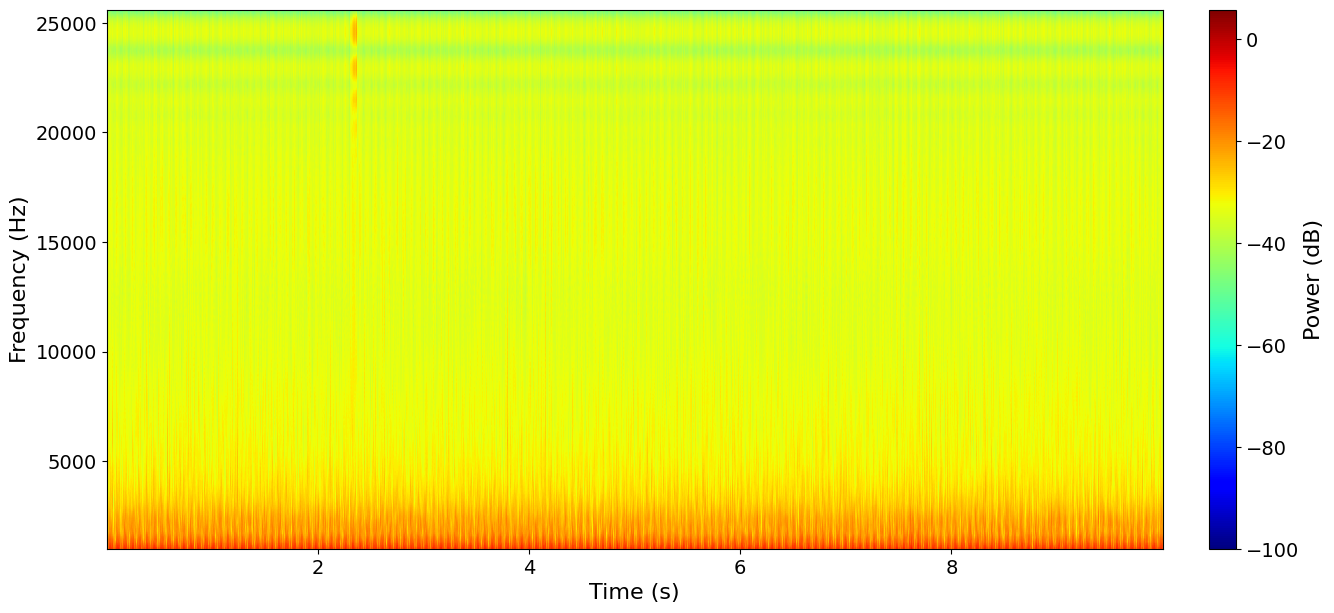

In [51]:
title_size = 18
label_size = 16
tick_size = 14

# Find the indices of frequencies within the desired range
frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# Ensure frequency_indices is 1D and properly formatted
frequency_indices = np.ravel(frequency_indices)

# Filter the frequencies and coefficients accordingly
masked_frequencies = frequencies[frequency_indices]

# Specify the desired timeframe range
start_timeframe = start_time
end_timeframe = end_time
# start_timeframe = 205
# end_timeframe = 210

# Find the indices of the time within the desired range
if end_timeframe is not None:
    time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
else:
    time_indices = np.where((time >= start_timeframe))[0]

# Ensure time_indices is 1D and properly formatted
time_indices = np.ravel(time_indices)

masked_timeframe = time[time_indices]

# Corrected indexing for power_db
# Using frequency_indices and time_indices to slice power_db
masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
print("masked_power_db shape:", masked_power_db.shape)


fig, ax1 = plt.subplots(figsize=(16, 7))

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_power_db, 
    extent=[masked_timeframe[0], masked_timeframe[-1], masked_frequencies[-1], masked_frequencies[0]],  # TODO: I think the y-scale is messed up on the graph because the y-axis of masked_power_db is not linear 
    # interpolation='bilinear', 
    cmap='jet', 
    aspect='auto', 
    vmax=max_value, 
    vmin=min_value
)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)
# ax1.set_title('FL-98 (Heavy 2-Phase Flow) Scalogram', fontsize=title_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_yscale('log')
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

In [50]:
raise Exception()

Exception: 

In [52]:
# # Find the indices of frequencies within the desired range
# frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# # Ensure frequency_indices is 1D and properly formatted
# frequency_indices = np.ravel(frequency_indices)

# # Filter the frequencies and coefficients accordingly
# masked_frequencies = frequencies[frequency_indices]

# print("power_db shape:", power_db.shape)  # (16, 1279999)
# print("frequency_indices:", frequency_indices)  # Should be 1D array

# # Specify the desired timeframe range
# start_timeframe = start_time
# end_timeframe = end_time
# # start_timeframe = 205
# # end_timeframe = 210

# # Find the indices of the time within the desired range
# if end_timeframe is not None:
#     time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
# else:
#     time_indices = np.where((time >= start_timeframe))[0]

# # Ensure time_indices is 1D and properly formatted
# time_indices = np.ravel(time_indices)

# masked_timeframe = time[time_indices]

# print("time_indices:", time_indices)  # Should be 1D array

# # Corrected indexing for power_db
# # Using frequency_indices and time_indices to slice power_db
# masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
# print(power_db)

# print("masked_power_db shape:", masked_power_db.shape)


# fig, ax1 = plt.subplots(figsize=(16, 8))

# # TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
# scalogram_image = ax1.pcolormesh(
#     time, frequencies, masked_power_db, 
#     cmap='jet',
#     shading='gouraud',  # or 'flat' if you want exact cell boundaries
#     vmax=max_value,
#     vmin=min_value
# )

# ax1.set_ylabel('Frequency (Hz)')
# ax1.set_xlabel('Time (s)')
# ax1.set_title('Scalogram (Wavelet Transform)')

# # Format the y-axis to show whole numbers instead of scientific notation
# ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# # Adjust the space between the graph and colorbar
# plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# cbar = fig.colorbar(scalogram_image, ax=[ax1, ax2], fraction=0.05, pad=0.04)
# cbar.set_label('Power (dB)')

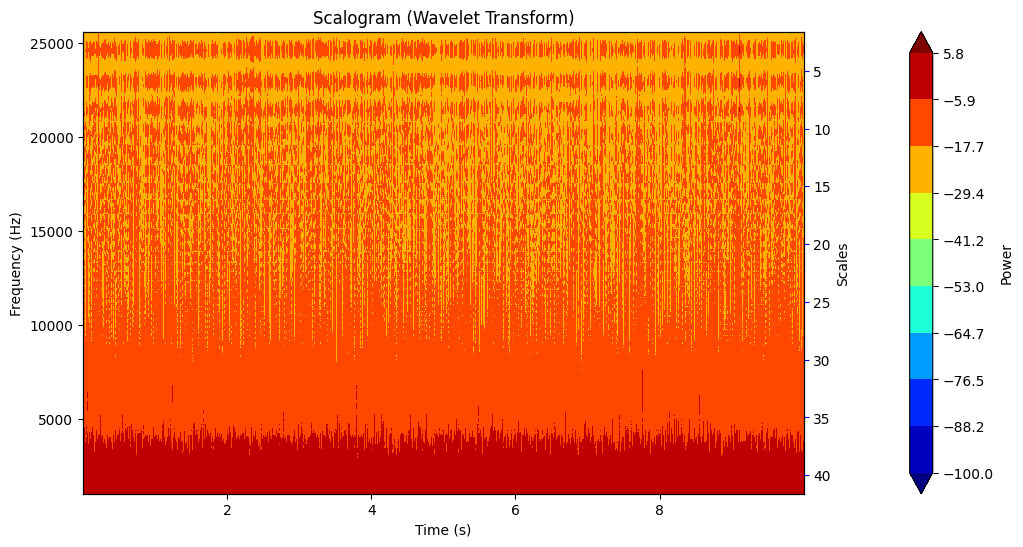

In [53]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(time, frequencies, power_db, levels=full_scalogram_levels, cmap='jet', extend='both')
# scalogram = ax1.pcolormesh(time, frequencies, power_db, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
# ax1.set_yscale('log')
# ax1.set_xlim([1, 1.05])

ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

# # Create a third axis to plot "time" vs "signal" with a linear y-axis
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Move the third axis further out
# ax3.set_ylabel('Signal', color='g')
# ax3.plot(time, signal, color='g')  # Plot time vs signal
# ax3.tick_params(axis='y', labelcolor='g')
# ax3.set_yscale('linear')  # Ensure the y-axis is linear

plt.show()

## Time-Masked Scalogram (adjust xmin, xmax, max_magnitude to zoom and adjust contrast)

In [54]:
xmin = 43.02  # Default 0
xmax = xmin + 0.01  # Use none to designate no end
n_color_contours = 64

mask = time > xmin
if xmax:
    mask = mask & (time < xmax)

masked_time_array = time[mask]
masked_power_array = power[:, mask]
masked_power_db_array = power_db[:, mask]
masked_signal = signal[mask]

levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

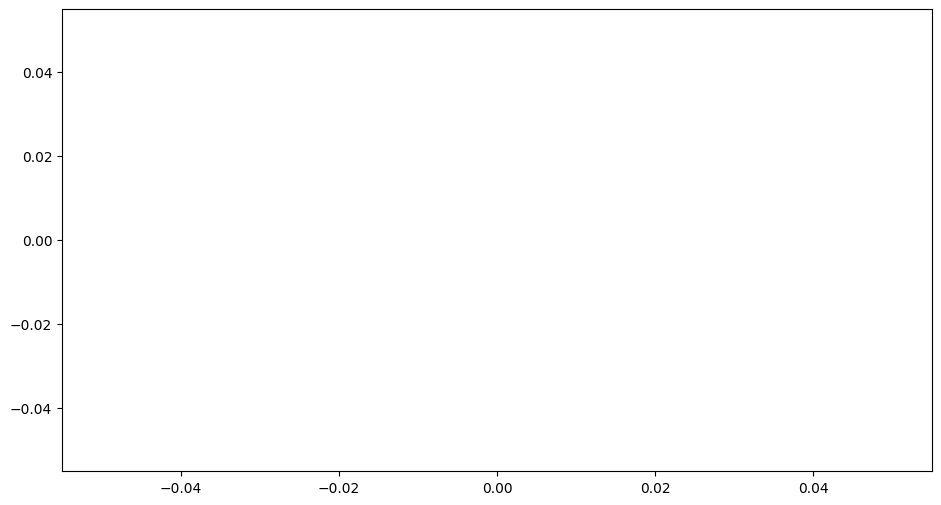

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (256, 0)

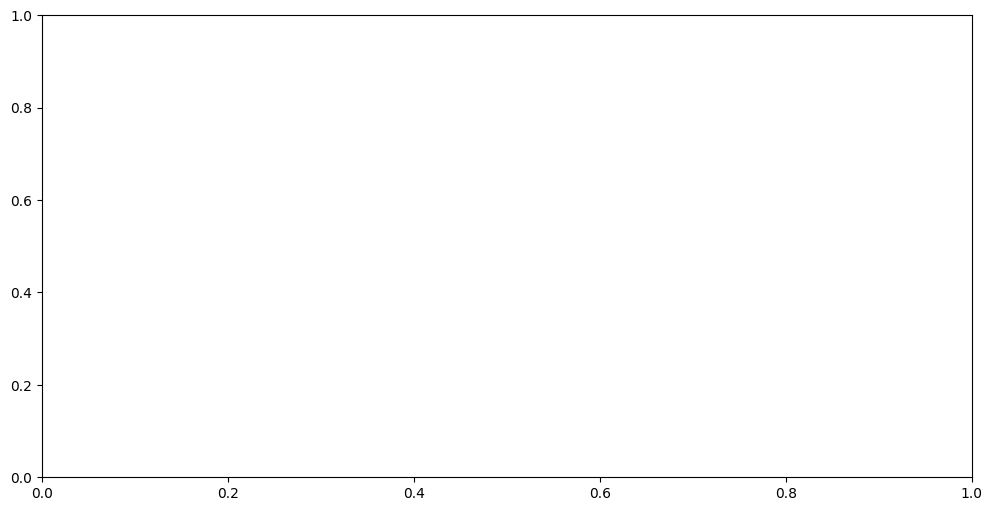

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

zoom_mask = (time > xmin) & (time < xmax)
ax.plot(time[zoom_mask], signal[zoom_mask])

# Adjust the space between the graph and the right edge to match the contourf() plot
plt.subplots_adjust(right=0.85)

plt.show()



fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(masked_time_array, frequencies, masked_power_db_array, levels=levels, cmap='jet', extend='both')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

plt.show()

In [ ]:
# # Define the bandpass filter parameters
# lowcut = 1000  # Lower frequency (Hz)
# highcut = 5000  # Upper frequency (Hz)

# # Butterworth bandpass filter design
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs  # Nyquist frequency
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     return b, a

# # Apply the filter to the signal
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = scipy.signal.filtfilt(b, a, data)
#     return y

# # Filter the signal
# filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency)

# plt.figure(figsize=(10, 6))
# plt.plot(time[zoom_mask], filtered_signal[zoom_mask], label='Filtered Signal (Bandpass)', color='r')
# plt.title(f'Filtered Signal (Bandpass: {lowcut}Hz - {highcut}Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

## Statistical Analysis of Time-Masked Signal

In [56]:
N = np.size(masked_signal)
mean = np.mean(masked_signal)
variance = np.var(masked_signal)  # Population variance
st_dev = math.sqrt(variance)
shapiro_test = stats.shapiro(masked_signal)
ks_test = stats.kstest(masked_signal, 'norm')
anderson_test = stats.anderson(masked_signal, dist='norm')

print(f"# of Points: {N}")
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Shapiro Test p-value: {shapiro_test.pvalue}")
print(f"K-S Test p-value: {ks_test.pvalue}")
print(anderson_test)

# # Create a histogram
# plt.figure(figsize=(12,5))
# plt.hist(signal, bins=200, edgecolor='black', alpha=0.7)
# plt.title('Histogram of the Data Distribution')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.xlim([mean-3*st_dev,mean+3*st_dev])
# plt.show()

# # KDE plot to smooth over the low-resolution signal
# sns.kdeplot(signal, shade=True)
# plt.title('KDE Plot of Low-Resolution Signal')
# plt.xlabel('Value')
# plt.ylabel('Density')
# # plt.axvline(x=mean-2*st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean-st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean, color='r', linestyle='--',)
# plt.axvline(x=mean+st_dev, color='r', linestyle='--',)
# # plt.axvline(x=mean+2*st_dev, color='r', linestyle='--',)
# plt.show()

# Q-Q Plot: If the data is normally distributed, the points in the Q-Q plot will roughly follow a straight diagonal line.
stats.probplot(masked_signal, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

c:\Users\sapierso\AppData\Local\anaconda3\envs\DataDroid\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sapierso\AppData\Local\anaconda3\envs\DataDroid\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\sapierso\AppData\Local\anaconda3\envs\DataDroid\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sapierso\AppData\Local\anaconda3\envs\DataDroid\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\sapierso\AppData\Local\anaconda3\envs\DataDroid\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = 

ZeroDivisionError: float division by zero

In [ ]:
# # Calculate mean and standard deviation
# mean = np.mean(signal)
# std_dev = np.std(signal)

# # Perform KDE using scipy's gaussian_kde
# kde = gaussian_kde(signal)

# # Create an x-axis range for plotting and integration
# x = np.linspace(min(signal), max(signal), 1000)

# # Evaluate the KDE for the x-axis
# kde_values = kde(x)

# # Plot the KDE
# plt.plot(x, kde_values, label='KDE')
# plt.fill_between(x, kde_values, alpha=0.5)

# # Add vertical lines for ±1σ, ±2σ, and ±3σ
# plt.axvline(mean - std_dev, color='green', linestyle='--', label='1σ')
# plt.axvline(mean + std_dev, color='green', linestyle='--')
# plt.axvline(mean - 2*std_dev, color='blue', linestyle='--', label='2σ')
# plt.axvline(mean + 2*std_dev, color='blue', linestyle='--')
# plt.axvline(mean - 3*std_dev, color='red', linestyle='--', label='3σ')
# plt.axvline(mean + 3*std_dev, color='red', linestyle='--')

# # Define the KDE function for integration
# def kde_function(x_val):
#     return kde(x_val)

# # Numerically integrate the KDE for 1σ, 2σ, and 3σ
# area_1sigma, _ = quad(kde_function, mean - std_dev, mean + std_dev)
# area_2sigma, _ = quad(kde_function, mean - 2*std_dev, mean + 2*std_dev)
# area_3sigma, _ = quad(kde_function, mean - 3*std_dev, mean + 3*std_dev)

# # Integrate the entire KDE (total area)
# total_area, _ = quad(kde_function, min(signal), max(signal))

# # Calculate the percentage of area within 1σ, 2σ, and 3σ
# percentage_within_1sigma = (area_1sigma / total_area) * 100
# percentage_within_2sigma = (area_2sigma / total_area) * 100
# percentage_within_3sigma = (area_3sigma / total_area) * 100

# # Add title and labels
# plt.title(f"KDE Plot with {percentage_within_1sigma:.2f}% within 1σ, "
#           f"{percentage_within_2sigma:.2f}% within 2σ, "
#           f"{percentage_within_3sigma:.2f}% within 3σ")
# plt.legend()

# # Show plot
# plt.show()

# # Print the results
# print(f"Percentage of area within 1 standard deviation: {percentage_within_1sigma:.2f}%")
# print(f"Percentage of area within 2 standard deviations: {percentage_within_2sigma:.2f}%")
# print(f"Percentage of area within 3 standard deviations: {percentage_within_3sigma:.2f}%")

In [ ]:
# Calculate the power spectrum of the wavelet transform (magnitude squared of coefficients)
power_spectrum = abs_coefficients_copy[:] ** 2

# Compute the mean power spectrum of the baseline
masked_mean_power_spectrum  = np.mean(masked_power_array, axis=1)

dof = 2  # DOF=2 because in a complex-valued signal, both the real and imaginary parts contribute to the power

# Using chi2.cdf to convert power spectrum values to confidence levels
# chi2.cdf returns the probability that a chi-squared random variable with 'dof' DOF 
# will be less than or equal to a given value (power in this case)
confidence_array = chi2.cdf(power_spectrum / masked_mean_power_spectrum[:, np.newaxis], dof)
masked_confidence_array = chi2.cdf(masked_power_array / masked_mean_power_spectrum[:, np.newaxis], dof)

# Compute the power levels corresponding to an n% confidence level at each frequency/scale
confidence_percentage = 99.0
confidence = confidence_percentage / 100
confidence_level_power = chi2.ppf(confidence, df=2) * masked_mean_power_spectrum

# Convert confidence level from power to magnitude by taking the square root
confidence_level_magnitude = np.sqrt(confidence_level_power)

"""Curve Fit for Noise Following a Power Law"""
# Mask Frequencies above the Sensor's Level of Attenuation
max_sensor_frequency = 10000
mask = frequencies < 10000

# Define the power-law function
def power_law(f, k, alpha):
    return k * f ** (-alpha)

# Initial guess for k and alpha
initial_guess = [1e-3, 1]

# Perform curve fitting
params, covariance = curve_fit(power_law, frequencies[mask], masked_mean_power_spectrum[mask], p0=initial_guess)
k_fitted, alpha_fitted = params
print(f"Fitted k: {k_fitted}")
print(f"Fitted alpha: {alpha_fitted}")

# Compute the fitted power values
P_fitted = power_law(frequencies, k_fitted, alpha_fitted)

# Plot the original data and the fitted curve
plt.figure()
plt.plot(frequencies, masked_mean_power_spectrum, label='Original Data')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--', label="Max Sensor Frequency")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power vs. Frequency with Fitted Power Law')
plt.legend()
plt.show()

# Visualize the baseline power and the confidence intervals for reference
plt.plot(frequencies, masked_mean_power_spectrum, label='Mean Power')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.xlim([0, 100])
plt.gca().set_ylim(bottom=0)
plt.show()

In [ ]:
# Get the confidences for every scale for a magnitude level on the scalogram
def get_confidence_levels(magnitude: float, mean_power_spectrum, dof=2):
    if magnitude > 1 or magnitude < 0:
        raise Exception("Magnitude must be a number between 0 and 1")
    n_scales = mean_power_spectrum.shape[0]
    magnitude_coefficients = np.full(n_scales, magnitude)
    power_spectrum = magnitude_coefficients ** 2
    confidence_levels = chi2.cdf(power_spectrum / mean_power_spectrum, dof)
    return confidence_levels

confidence_levels_for_certain_magnitude = get_confidence_levels(magnitude=0.01, mean_power_spectrum=masked_mean_power_spectrum)
np.set_printoptions(precision=15)
print(confidence_levels_for_certain_magnitude)
np.set_printoptions(precision=8)

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Overlay confidence contours (in magnitude)
scalogram = ax1.contourf(time, frequencies, power, levels=full_scalogram_levels, cmap='jet', extend='both')
# Overlay the single filled contour
contour = ax1.contourf(time, frequencies, confidence_array, levels=[0.999999999999998, 1], colors='white', alpha=.5)

ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')
# ax1.set_xlim([12.2, 12.21])
plt.show()

## Full Scalogram Plotted with Colormesh Method

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.pcolormesh(time, frequencies, power, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')

plt.show()